# Titanic Dataset with Scikit-Learn

## Imports

In [1]:
# Basic imports
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

## Utilizing functions created earlier for EDA

In [2]:
# Helper functions for preprocessing
def extract_first_letter(cabin):
	'''
	Extracting the first letter from a given cabin number. If the input is
	different, function returns 'NaN'.
	'''
	if type(cabin) == type('a'):
		return cabin[0]
	return 'X'

def extract_cabin_number(data):
	'''
	Extracting the number of the cabin. If there's none, returns NaN.
	'''
	if data['Cabin_letter'] != 'X':
		return data['Cabin'][1:]
	return 0

def title_extraction(title):
	'''
	Extracting the title from the 'Name' column.
	'''
	temp = title.split()

	for i in range(len(temp)):
		if '.' in temp[i]:
			return temp[i].split('.')[0]

def title_condensation(data):
	'''
	Condensing the amount of titles to smaller value.
	'''
	if data['Title'] in ['Miss', 'Mlle', 'Ms']:
		return 'Miss'
	
	elif data['Title'] in ['Mrs', 'Countess', 'Lady', 'Mme']:
		return 'Mrs'

	elif data['Title'] == 'Dr' and data['Sex'] == 'female':
		return 'Mrs'
		
	else:
		return 'Mr'

def age_filler2(data):
	'''
	Fills up the NaN with proper age mean according to 
	title_condensed value. If age is already there, it's being
	carried unchanged.
	'''
	miss_mean = np.float64(data.groupby('Title_condensed')['Age'].mean()['Miss'])
	mr_mean = np.float64(data.groupby('Title_condensed')['Age'].mean()['Mr'])
	mrs_mean = np.float64(data.groupby('Title_condensed')['Age'].mean()['Mrs'])

	if data['Age_nan_True']:
		if data['Title_condensed'] == 'Miss':
			return miss_mean

		elif data['Title_condensed'] == 'Mr':
			return mr_mean

		elif data['Title_condensed'] == 'Mrs':
			return mrs_mean
	
	return data['Age']

def age_filler(data):
	if data['Age_nan_True']:
		if data['Title_condensed'] == 'Mrs':
			return 35.99

		if data['Title_condensed'] == 'Mr':
			return 30.73

		if data['Title_condensed'] == 'Miss':
			return 21.76
	
	return np.float64(data['Age'])


In [3]:
# Function to preprocess the data engineering part
def preprocessing(titanic):
	'''
	Function that preprocesses the data enginnering/feature engineering
	part of loaded DataFrame.
	'''	

	print("PREPROCESSING...")

	# Dropping top 0,5% of 'Fare' entries
	if len(titanic)>500:
		for i in range(int(len(titanic)/200)):
			titanic.drop(titanic['Fare'].idxmax(), axis=0, inplace=True)

	print("Top 0,5% 'Fare' entries dropped")

	# Extract cabin letter and number
	titanic['Cabin_letter'] = titanic['Cabin'].apply(lambda x: extract_first_letter(x))
	titanic['Cabin_number'] = titanic.apply(extract_cabin_number, axis=1)
	
	# Change type of cabin number column to numeric values
	titanic['Cabin_number'] = pd.to_numeric(titanic['Cabin_number'], errors='ignore')
	titanic['Cabin_number'].fillna(0)
	print('Cabin column done')

	# Create family size value column
	titanic['Family_size'] = titanic['SibSp'] + titanic['Parch'] + 1
	print('Family size created')

	# Create Fare per person column
	titanic['Fare_per_person'] = titanic['Fare'] / titanic['Family_size']
	print('Fare per person created')

	# Extracting the title from the name and making the total number smaller
	titanic['Title'] = titanic['Name'].apply(lambda x: title_extraction(x))
	titanic['Title_condensed'] = titanic.apply(title_condensation, axis=1)
	print('Titles extracted and condensed')

	# Calculating the mean age values per each title
	#miss_mean = titanic.groupby('Title_condensed')['Age'].mean()['Miss']
	#mr_mean = titanic.groupby('Title_condensed')['Age'].mean()['Mr']
	#mrs_mean = titanic.groupby('Title_condensed')['Age'].mean()['Mrs']

	# Filling the missing age values
	titanic['Age_nan_True'] = titanic['Age'].isna()
	titanic['Age_filled'] = titanic.apply(age_filler, axis=1)
	print('Age column filled')

	# Filling the missing fare values
	titanic['Fare'] = titanic['Fare'].fillna(titanic['Fare'].mean())
	print('Filling the missing fare values')

	# Dropping unnecessary columns
	del_cols = ['Cabin', 'Age', 'Age_nan_True', 'Title', 'Name', 'Ticket', 'PassengerId', 'Cabin_number']
	titanic.drop(del_cols, axis=1, inplace=True)	
	print('Columns deleted')

	print('PREPROCESSING DONE\n')

	# Return the preprocessed DataFrame
	return titanic

In [4]:
# One hot encode the features and normalize the data in the set
def onehot_normalize(data):

	from sklearn.compose import make_column_transformer
	from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
	from sklearn.model_selection import train_test_split

	print('ONE-HOT ENCODING AND NORMALIZATION...')

	# Split the columns into linear and categorical ones
	linear_cols = ['Pclass', 'SibSp', 'Parch', 'Fare', 'Family_size',
					'Fare_per_person', 'Age_filled']
	
	categorical_cols = ['Sex', 'Embarked', 'Cabin_letter', 'Title_condensed']

	# Create a column transformer
	ct = make_column_transformer(
		(MinMaxScaler(), linear_cols),
		(OneHotEncoder(handle_unknown='ignore'), categorical_cols)
	)
	print('Column transformer instentiated')

	# Create X and y sets
	X = data.drop('Survived', axis=1)
	y = data['Survived']

	# Split the data
	X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
	print('Data split into train and test sets')

	# Fit the column transformer
	ct.fit(X_train)

	# Transform the train and test sets
	X_train_norm = ct.transform(X_train)
	X_test_norm = ct.transform(X_test)
	print('Columns transformed')

	print('ONE-HOT ENCODING AND NORMALIZATION FINISHED')

	return X_train_norm, X_test_norm, y_train, y_test, X, y

In [5]:
# One hot encode the features and normalize the data in the set
def onehot_normalize_2(data):

	from sklearn.compose import make_column_transformer
	from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
	from sklearn.model_selection import train_test_split

	print('ONE-HOT ENCODING AND NORMALIZATION...')

	# Split the columns into linear and categorical ones
	linear_cols = ['Pclass', 'SibSp', 'Parch', 'Fare', 'Family_size',
					'Fare_per_person', 'Age_filled']
	
	categorical_cols = ['Sex', 'Embarked', 'Cabin_letter', 'Title_condensed']
	
	# Create a column transformer
	ct = make_column_transformer(
		(MinMaxScaler(), linear_cols),
		(OneHotEncoder(handle_unknown='ignore'), categorical_cols)
	)
	print('Column transformer instentiated')

	# Create X and y sets
	X = data.drop('Survived', axis=1)
	#X = pd.get_dummies(data=X)
	y = data['Survived']

	# Split the data
	X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
	print('Data split into train and test sets')

	# Fit the column transformer
	ct.fit(X_train)

	# Transform the train and test sets
	X_train_norm = ct.transform(X_train)
	X_test_norm = ct.transform(X_test)
	print('Columns transformed')

	print('ONE-HOT ENCODING AND NORMALIZATION FINISHED')

	return X_train_norm, X_test_norm, y_train, y_test

In [6]:
# Load in the data
titanic_train = pd.read_csv('train.csv')

# Preprocessing
titanic_train = preprocessing(titanic_train)

# One-hot encoding, normalization, train/test split
X_train, X_test, y_train, y_test = onehot_normalize_2(titanic_train)

PREPROCESSING...
Top 0,5% 'Fare' entries dropped
Cabin column done
Family size created
Fare per person created
Titles extracted and condensed
Age column filled
Filling the missing fare values
Columns deleted
PREPROCESSING DONE

ONE-HOT ENCODING AND NORMALIZATION...
Column transformer instentiated
Data split into train and test sets
Columns transformed
ONE-HOT ENCODING AND NORMALIZATION FINISHED


## Basic RFC model

In [38]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, f1_score

# Creating a RFC model
rfc_basic = RandomForestClassifier(random_state=42, verbose=0)

# Fitting model to the data
rfc_basic.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

In [39]:
# Function to evaluate the model
def evaluate_model(model, model_name, y_true, X_test=X_test):

	# Calculate predictions
	pred = model.predict(X_test)

	# Basic metrics
	print(f'EVALUATION METRICS FOR MODEL: {model_name}\n')

	print('Confusion matrix: ')
	print(confusion_matrix(y_true, pred))

	print('\nClassification report: ')
	print(classification_report(y_true, pred))

	acc = accuracy_score(y_true, pred)
	f1 = accuracy_score(y_true, pred)

	print('Scores for basic model')
	print(f'Accuracy score: {acc:.3f}')
	print(f'F1-score: {f1:.3f}')
	"""
	# Feature importance
	feature_imp = pd.DataFrame(model.feature_importances_, 
								index = X.columns, 
								columns=['Feature importance score']).sort_values(ascending=False,
																				by=['Feature importance score'])

	sns.barplot(x=feature_imp['Feature importance score'], y=feature_imp.index)
	"""
	score = [[model_name, acc]]
	return score

In [40]:
rfc_basic_results = evaluate_model(model=rfc_basic, model_name='rfc_basic', y_true=y_test)

EVALUATION METRICS FOR MODEL: rfc_basic

Confusion matrix: 
[[90 16]
 [21 51]]

Classification report: 
              precision    recall  f1-score   support

           0       0.81      0.85      0.83       106
           1       0.76      0.71      0.73        72

    accuracy                           0.79       178
   macro avg       0.79      0.78      0.78       178
weighted avg       0.79      0.79      0.79       178

Scores for basic model
Accuracy score: 0.792
F1-score: 0.792


### RFC with GridSearchCV

Baseline to beat is 78.1%. Let's try using GridSearchCV to improve our score by trying different hyperparameters.

In [41]:
from sklearn.model_selection import GridSearchCV

param_grid_rfc = {
	'n_estimators': [512, 1024],
	'max_features': ['sqrt', 'log2'],
	'max_depth': [5, 7, 9, 11],
	'criterion': ['gini']
}

rfc_cv = RandomForestClassifier(random_state=42, verbose=0, n_jobs=-1)

cv_rfc = GridSearchCV(estimator=rfc_cv, 
					  param_grid=param_grid_rfc)

cv_rfc.fit(X_train, y_train)

print(f'Best params: {cv_rfc.best_params_}')
print(f'Best score: {cv_rfc.best_score_}')

Best params: {'criterion': 'gini', 'max_depth': 9, 'max_features': 'sqrt', 'n_estimators': 1024}
Best score: 0.8420537408850265


In [42]:
print(f"Best score: {cv_rfc.best_score_}")
print(f"Best estimator: {cv_rfc.best_estimator_}")
print(f"Best params: {cv_rfc.best_params_}")


Best score: 0.8420537408850265
Best estimator: RandomForestClassifier(max_depth=9, n_estimators=1024, n_jobs=-1,
                       random_state=42)
Best params: {'criterion': 'gini', 'max_depth': 9, 'max_features': 'sqrt', 'n_estimators': 1024}


In [43]:
# Training the RFC with GridSearchCV best params found
rfc_cv = RandomForestClassifier(random_state=42, 
								verbose=0,
								criterion=cv_rfc.best_params_['criterion'],
								max_depth=cv_rfc.best_params_['max_depth'],
								max_features=cv_rfc.best_params_['max_features'],
								n_estimators=cv_rfc.best_params_['n_estimators'])

rfc_cv.fit(X_train, y_train)

rfc_cv_results = evaluate_model(model=rfc_cv, model_name='rfc_cv', y_true=y_test)

EVALUATION METRICS FOR MODEL: rfc_cv

Confusion matrix: 
[[92 14]
 [22 50]]

Classification report: 
              precision    recall  f1-score   support

           0       0.81      0.87      0.84       106
           1       0.78      0.69      0.74        72

    accuracy                           0.80       178
   macro avg       0.79      0.78      0.79       178
weighted avg       0.80      0.80      0.80       178

Scores for basic model
Accuracy score: 0.798
F1-score: 0.798


## Creating DataFrame to store results

In [44]:
# Function to append data from each experiment
def append_data(df, data):
    if isinstance(data, pd.DataFrame):
        # If data is already a DataFrame, we can simply concatenate it to the original DataFrame
        new_df = pd.concat([df, data], ignore_index=True)
    elif isinstance(data, list):
        # If data is a list, we need to convert it to a DataFrame first
        new_df = pd.concat([df, pd.DataFrame(data, columns=df.columns)], ignore_index=True)
    else:
        raise ValueError("Data must be either a list or a DataFrame.")
    
    return new_df

In [45]:
# Creating DataFrame to store results
results = pd.DataFrame(columns=['Model', 'Accuracy'])
results

,Model,Accuracy


In [46]:
# Adding already obtained data
results = append_data(results, rfc_basic_results)
results = append_data(results, rfc_cv_results)
results

,Model,Accuracy
0,rfc_basic,0.792135
1,rfc_cv,0.797753


## Next experiments - Gaussian Naive-Bayes

Other classifiers to try out:
* CatBoost
* Gradient Boosting Trees
* Decision Tree
* Logistic Regression
* Naive Bayes
* KNN
* Linear SVC
* Stochastic Gradient Descent

In [47]:
# Next model - Gaussian Naive-Bayes
from sklearn.naive_bayes import GaussianNB
gnb = GaussianNB()

gnb.fit(X_train, y_train)

gnb.predict(X_test)

gnb_results = evaluate_model(model=gnb, model_name='gnb', y_true=y_test)

EVALUATION METRICS FOR MODEL: gnb

Confusion matrix: 
[[91 15]
 [27 45]]

Classification report: 
              precision    recall  f1-score   support

           0       0.77      0.86      0.81       106
           1       0.75      0.62      0.68        72

    accuracy                           0.76       178
   macro avg       0.76      0.74      0.75       178
weighted avg       0.76      0.76      0.76       178

Scores for basic model
Accuracy score: 0.764
F1-score: 0.764


In [48]:
# Appending the results
results = append_data(results, gnb_results)
results

,Model,Accuracy
0,rfc_basic,0.792135
1,rfc_cv,0.797753
2,gnb,0.764045


## Logistic Regression

In [49]:
from sklearn.linear_model import LogisticRegression
log = LogisticRegression(random_state=42)

log.fit(X_train, y_train)

log_results = evaluate_model(model=log, model_name='log_regression', y_true=y_test)

results = append_data(results, log_results)
results

EVALUATION METRICS FOR MODEL: log_regression

Confusion matrix: 
[[93 13]
 [28 44]]

Classification report: 
              precision    recall  f1-score   support

           0       0.77      0.88      0.82       106
           1       0.77      0.61      0.68        72

    accuracy                           0.77       178
   macro avg       0.77      0.74      0.75       178
weighted avg       0.77      0.77      0.76       178

Scores for basic model
Accuracy score: 0.770
F1-score: 0.770


,Model,Accuracy
0,rfc_basic,0.792135
1,rfc_cv,0.797753
2,gnb,0.764045
3,log_regression,0.769663


### Logistic Regression - Ridge

In [50]:
from sklearn.linear_model import RidgeClassifier
ridge = RidgeClassifier(random_state=42)

ridge.fit(X_train, y_train)

ridge_results = evaluate_model(model=ridge, model_name='ridge', y_true=y_test)

results = append_data(results, ridge_results)
results

EVALUATION METRICS FOR MODEL: ridge

Confusion matrix: 
[[92 14]
 [28 44]]

Classification report: 
              precision    recall  f1-score   support

           0       0.77      0.87      0.81       106
           1       0.76      0.61      0.68        72

    accuracy                           0.76       178
   macro avg       0.76      0.74      0.75       178
weighted avg       0.76      0.76      0.76       178

Scores for basic model
Accuracy score: 0.764
F1-score: 0.764


,Model,Accuracy
0,rfc_basic,0.792135
1,rfc_cv,0.797753
2,gnb,0.764045
3,log_regression,0.769663
4,ridge,0.764045


### Logistic Regression - GridSearchCV

In [51]:
# Using GridSearchCV to optimize the Logistic Regression model
param_grid_log = {
	'penalty': ['elasticnet', 'l2'],
	'C': [0.01, 0.1, 1, 10],
	'solver': ['liblinear', 'newton_cholesky', 'lbfgs', 'saga'],
	'max_iter': [10, 30, 50, 100]
}

log_cv = LogisticRegression(random_state=42, verbose=0)

cv_log = GridSearchCV(estimator=log_cv, 
					  param_grid=param_grid_log)

cv_log.fit(X_train, y_train)

# Print results
print(f"Best score: {cv_log.best_score_}")
print(f"Best estimator: {cv_log.best_estimator_}")
print(f"Best params: {cv_log.best_params_}")

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://sciki

Best score: 0.812446309060034
Best estimator: LogisticRegression(C=10, max_iter=10, random_state=42)
Best params: {'C': 10, 'max_iter': 10, 'penalty': 'l2', 'solver': 'lbfgs'}


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:378: FitFailedWarning

In [52]:
log_cv = LogisticRegression(random_state=42,
							verbose=0,
							penalty=cv_log.best_params_['penalty'],
							C=cv_log.best_params_['C'],
							solver=cv_log.best_params_['solver'],
							max_iter=cv_log.best_params_['max_iter'])

log_cv.fit(X_train, y_train)

log_cv_results = evaluate_model(log_cv, 'log_regression_cv', y_test)

results = append_data(results, log_cv_results)
results

EVALUATION METRICS FOR MODEL: log_regression_cv

Confusion matrix: 
[[92 14]
 [25 47]]

Classification report: 
              precision    recall  f1-score   support

           0       0.79      0.87      0.83       106
           1       0.77      0.65      0.71        72

    accuracy                           0.78       178
   macro avg       0.78      0.76      0.77       178
weighted avg       0.78      0.78      0.78       178

Scores for basic model
Accuracy score: 0.781
F1-score: 0.781


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


,Model,Accuracy
0,rfc_basic,0.792135
1,rfc_cv,0.797753
2,gnb,0.764045
3,log_regression,0.769663
4,ridge,0.764045
5,log_regression_cv,0.780899


## K Nearest Neighbours

In [53]:
from sklearn.cluster import KMeans

# Create KNN model
knn = KMeans(n_clusters=2, random_state=42)

# Fit the model
knn.fit(X_train)

# Check the centers 
knn.cluster_centers_

# Check the labels
knn.labels_

array([1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 0, 1,
       0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1,
       1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 0, 1, 1, 1, 0, 1, 0, 0,
       1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0,
       1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 0, 0,
       0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0,
       1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1,
       1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 0,
       1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1,
       0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0,
       0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1,
       0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0,

In [54]:
# Evaluation
knn_results = evaluate_model(knn, 'knn', y_test)

results = append_data(results, knn_results)
results

EVALUATION METRICS FOR MODEL: knn

Confusion matrix: 
[[16 90]
 [46 26]]

Classification report: 
              precision    recall  f1-score   support

           0       0.26      0.15      0.19       106
           1       0.22      0.36      0.28        72

    accuracy                           0.24       178
   macro avg       0.24      0.26      0.23       178
weighted avg       0.24      0.24      0.23       178

Scores for basic model
Accuracy score: 0.236
F1-score: 0.236


,Model,Accuracy
0,rfc_basic,0.792135
1,rfc_cv,0.797753
2,gnb,0.764045
3,log_regression,0.769663
4,ridge,0.764045
5,log_regression_cv,0.780899
6,knn,0.235955


## Support Vector Machines

In [55]:
from sklearn.svm import SVC

svc = SVC(random_state=42)

svc.fit(X_train, y_train)

svc_results = evaluate_model(svc, 'svc', y_test)

results = append_data(results, svc_results)
results

EVALUATION METRICS FOR MODEL: svc

Confusion matrix: 
[[93 13]
 [28 44]]

Classification report: 
              precision    recall  f1-score   support

           0       0.77      0.88      0.82       106
           1       0.77      0.61      0.68        72

    accuracy                           0.77       178
   macro avg       0.77      0.74      0.75       178
weighted avg       0.77      0.77      0.76       178

Scores for basic model
Accuracy score: 0.770
F1-score: 0.770


,Model,Accuracy
0,rfc_basic,0.792135
1,rfc_cv,0.797753
2,gnb,0.764045
3,log_regression,0.769663
4,ridge,0.764045
5,log_regression_cv,0.780899
6,knn,0.235955
7,svc,0.769663


### SVC with GridSearchCV

In [56]:
param_grid_svc = {
	'C': [0.01, 0.1, 1, 10, 100],
	'gamma': [1, 0.1, 0.01, 0.001, 0.001, 'scale'],
	'kernel': ['rbf']
}

svc_cv = SVC(random_state=42, verbose=0)

cv_svc = GridSearchCV(estimator=svc_cv,
					  param_grid=param_grid_svc)

cv_svc.fit(X_train, y_train)

# Results
print(f"Best params: {cv_svc.best_params_}")
print(f"Best score: {cv_svc.best_score_}")

Best params: {'C': 100, 'gamma': 1, 'kernel': 'rbf'}
Best score: 0.8392368394765757


In [57]:
# Create & train the model
svc_cv = SVC(random_state=42,
			 verbose=0,
			 C=cv_svc.best_params_['C'],
			 gamma=cv_svc.best_params_['gamma'],
			 kernel=cv_svc.best_params_['kernel'])

svc_cv.fit(X_train, y_train)

# Evaluate the model
svc_cv_results = evaluate_model(svc_cv, 'svc_cv', y_test)

EVALUATION METRICS FOR MODEL: svc_cv

Confusion matrix: 
[[96 10]
 [28 44]]

Classification report: 
              precision    recall  f1-score   support

           0       0.77      0.91      0.83       106
           1       0.81      0.61      0.70        72

    accuracy                           0.79       178
   macro avg       0.79      0.76      0.77       178
weighted avg       0.79      0.79      0.78       178

Scores for basic model
Accuracy score: 0.787
F1-score: 0.787


In [58]:
# Append the results
results = append_data(results, svc_cv_results)
results

,Model,Accuracy
0,rfc_basic,0.792135
1,rfc_cv,0.797753
2,gnb,0.764045
3,log_regression,0.769663
4,ridge,0.764045
5,log_regression_cv,0.780899
6,knn,0.235955
7,svc,0.769663
8,svc_cv,0.786517


In [28]:
results_full_data = results
results_full_data.sort_values('Accuracy', ascending=False)

,Model,Accuracy
0,rfc_basic,0.780899
1,rfc_cv,0.769663
3,log_regression,0.769663
4,ridge,0.758427
5,log_regression_cv,0.741573
7,svc,0.719101
8,svc_cv,0.719101
2,gnb,0.702247
6,knn,0.235955


## Summary of first part
Turned out that the first model was the best for this case being `RandomForestClassifier()`.

Let's check out how important were each and every feature for this model and try to enhance the preprocessing/normalization to boost the results a bit.

In [88]:
from sklearn.model_selection import train_test_split

X = titanic_train.drop('Survived', axis=1)
X = pd.get_dummies(X)
y = titanic_train['Survived']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

X_train_norm = scaler.fit_transform(X_train)
X_test_norm = scaler.transform(X_test)

In [89]:
rfc_feature = RandomForestClassifier(random_state=42, verbose=0)
rfc_feature.fit(X_train, y_train)

evaluate_model(rfc_feature, 'rfc_feature', y_test, X_test=X_test)

EVALUATION METRICS FOR MODEL: rfc_feature

Confusion matrix: 
[[90 16]
 [21 51]]

Classification report: 
              precision    recall  f1-score   support

           0       0.81      0.85      0.83       106
           1       0.76      0.71      0.73        72

    accuracy                           0.79       178
   macro avg       0.79      0.78      0.78       178
weighted avg       0.79      0.79      0.79       178

Scores for basic model
Accuracy score: 0.792
F1-score: 0.792


[['rfc_feature', 0.7921348314606742]]

In [90]:
def plot_feature_importance(model, model_name, X):
	feature_importance = pd.DataFrame(data=model.feature_importances_, 
								  index=X.columns, 
								  columns=['Feature importance'])


	sns.barplot(x=feature_importance['Feature importance'], 
			y=feature_importance.index,
			palette='viridis')
	
	plt.title(model_name)

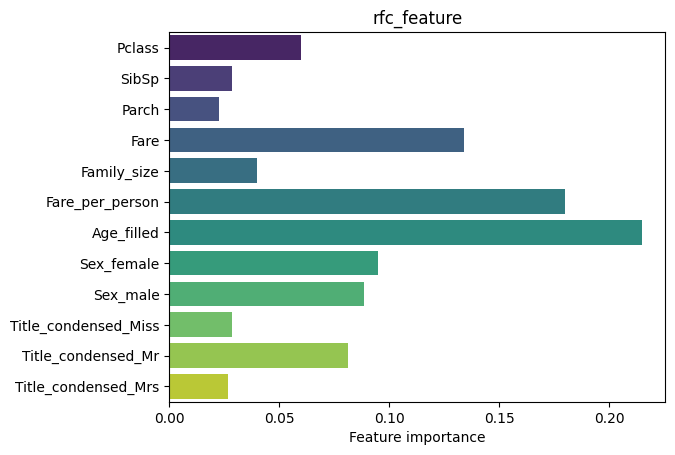

In [91]:
plot_feature_importance(model=rfc_feature, model_name='rfc_feature', X=X)

EVALUATION METRICS FOR MODEL: rfc_feature_norm

Confusion matrix: 
[[83 23]
 [22 50]]

Classification report: 
              precision    recall  f1-score   support

           0       0.79      0.78      0.79       106
           1       0.68      0.69      0.69        72

    accuracy                           0.75       178
   macro avg       0.74      0.74      0.74       178
weighted avg       0.75      0.75      0.75       178

Scores for basic model
Accuracy score: 0.747
F1-score: 0.747


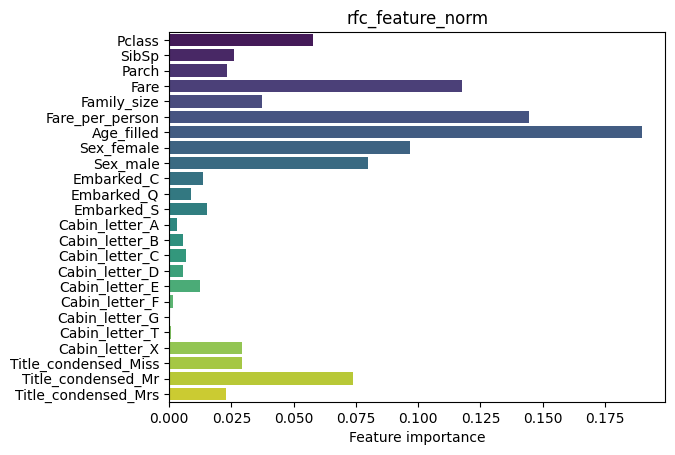

In [33]:
rfc_feature_norm = RandomForestClassifier(random_state=42, verbose=0)
rfc_feature_norm.fit(X_train_norm, y_train)

evaluate_model(rfc_feature_norm, 'rfc_feature_norm', y_test, X_test=X_test_norm)
plot_feature_importance(rfc_feature_norm, 'rfc_feature_norm', X_test)

It's very easy to see, that the 'Cabin letter' and 'Embarked' columns do not carry a lot of importance while making the decision of whether a passenger has survived. Let's make another attempt at preprocessing and ditch both of those features and compare the results.

# Attempt 2
This time we'll see if less parameters is better for this particular dataset.

## New preprocessing and normalization

In [34]:
# Using earlier created function to preprocess data
def preprocessing_2(titanic):
	'''
	Function that preprocesses the data enginnering/feature engineering
	part of loaded DataFrame.
	'''	

	print("PREPROCESSING...")

	# Dropping top 0,5% of 'Fare' entries
	if len(titanic)>500:
		for i in range(int(len(titanic)/200)):
			titanic.drop(titanic['Fare'].idxmax(), axis=0, inplace=True)

	print("Top 0,5% 'Fare' entries dropped")

	# Create family size value column
	titanic['Family_size'] = titanic['SibSp'] + titanic['Parch'] + 1
	print('Family size created')

	# Create Fare per person column
	titanic['Fare_per_person'] = titanic['Fare'] / titanic['Family_size']
	print('Fare per person created')

	# Extracting the title from the name and making the total number smaller
	titanic['Title'] = titanic['Name'].apply(lambda x: title_extraction(x))
	titanic['Title_condensed'] = titanic.apply(title_condensation, axis=1)
	print('Titles extracted and condensed')

	# Calculating the mean age values per each title
	#miss_mean = titanic.groupby('Title_condensed')['Age'].mean()['Miss']
	#mr_mean = titanic.groupby('Title_condensed')['Age'].mean()['Mr']
	#mrs_mean = titanic.groupby('Title_condensed')['Age'].mean()['Mrs']

	# Filling the missing age values
	titanic['Age_nan_True'] = titanic['Age'].isna()
	titanic['Age_filled'] = titanic.apply(age_filler, axis=1)
	print('Age column filled')

	# Filling the missing fare values
	titanic['Fare'] = titanic['Fare'].fillna(titanic['Fare'].mean())
	print('Filling the missing fare values')

	# Dropping unnecessary columns
	del_cols = ['Cabin', 'Age', 'Age_nan_True', 'Title', 'Name', 'Ticket', 'PassengerId', 'Cabin', 'Embarked']
	titanic.drop(del_cols, axis=1, inplace=True)	
	print('Columns deleted')

	print('PREPROCESSING DONE\n')

	# Return the preprocessed DataFrame
	return titanic

In [35]:
# One hot encode the features and normalize the data in the set
def onehot_normalize_3(data):

	from sklearn.compose import make_column_transformer
	from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
	from sklearn.model_selection import train_test_split

	print('ONE-HOT ENCODING AND NORMALIZATION...')

	# Split the columns into linear and categorical ones
	linear_cols = ['Pclass', 'SibSp', 'Parch', 'Fare', 'Family_size',
					'Fare_per_person', 'Age_filled']
	
	categorical_cols = ['Sex', 'Title_condensed']
	
	# Create a column transformer
	ct = make_column_transformer(
		(MinMaxScaler(), linear_cols),
		(OneHotEncoder(handle_unknown='ignore'), categorical_cols)
	)
	print('Column transformer instentiated')

	# Create X and y sets
	X = data.drop('Survived', axis=1)
	#X = pd.get_dummies(data=X)
	y = data['Survived']

	# Split the data
	X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
	print('Data split into train and test sets')

	# Fit the column transformer
	ct.fit(X_train)

	# Transform the train and test sets
	X_train_norm = ct.transform(X_train)
	X_test_norm = ct.transform(X_test)
	print('Columns transformed')

	print('ONE-HOT ENCODING AND NORMALIZATION FINISHED')

	return X_train_norm, X_test_norm, y_train, y_test

In [36]:
titanic_train = pd.read_csv('train.csv')
titanic_train = preprocessing_2(titanic_train)
X_train, X_test, y_train, y_test = onehot_normalize_3(titanic_train)

PREPROCESSING...
Top 0,5% 'Fare' entries dropped
Family size created
Fare per person created
Titles extracted and condensed
Age column filled
Filling the missing fare values
Columns deleted
PREPROCESSING DONE

ONE-HOT ENCODING AND NORMALIZATION...
Column transformer instentiated
Data split into train and test sets
Columns transformed
ONE-HOT ENCODING AND NORMALIZATION FINISHED


In [37]:
results_full_data

,Model,Accuracy
0,rfc_basic,0.780899
1,rfc_cv,0.769663
2,gnb,0.702247
3,log_regression,0.769663
4,ridge,0.758427
5,log_regression_cv,0.741573
6,knn,0.235955
7,svc,0.719101
8,svc_cv,0.719101


#

In [59]:
results_less_data = results
results_less_data

,Model,Accuracy
0,rfc_basic,0.792135
1,rfc_cv,0.797753
2,gnb,0.764045
3,log_regression,0.769663
4,ridge,0.764045
5,log_regression_cv,0.780899
6,knn,0.235955
7,svc,0.769663
8,svc_cv,0.786517


<AxesSubplot:xlabel='Accuracy', ylabel='Model'>

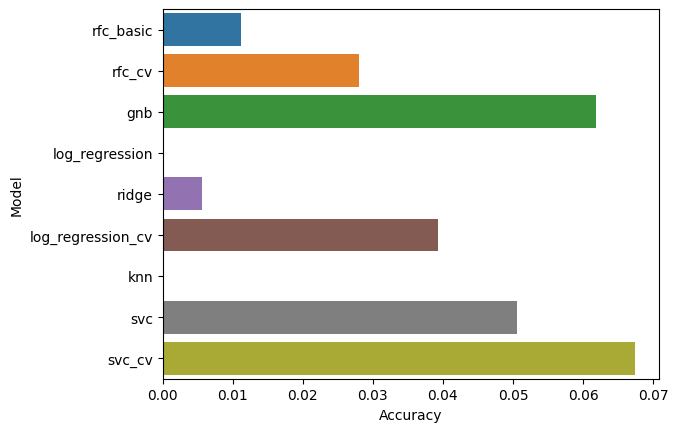

In [73]:
diff = results_less_data['Accuracy'] - results_full_data['Accuracy']
sns.barplot(x=diff, y=results_less_data['Model'])

Looks alike the best improvement is in the SVC models.

In [80]:
rfc_cv.feature_importances_.shape

(12,)

In [85]:
titanic_train

,Survived,Pclass,Sex,SibSp,Parch,Fare,Family_size,Fare_per_person,Title_condensed,Age_filled
0,0,3,male,1,0,7.2500,2,3.62500,Mr,22.00
1,1,1,female,1,0,71.2833,2,35.64165,Mrs,38.00
2,1,3,female,0,0,7.9250,1,7.92500,Miss,26.00
3,1,1,female,1,0,53.1000,2,26.55000,Mrs,35.00
4,0,3,male,0,0,8.0500,1,8.05000,Mr,35.00
...,...,...,...,...,...,...,...,...,...,...
886,0,2,male,0,0,13.0000,1,13.00000,Mr,27.00
887,1,1,female,0,0,30.0000,1,30.00000,Miss,19.00
888,0,3,female,1,2,23.4500,4,5.86250,Miss,21.76
889,1,1,male,0,0,30.0000,1,30.00000,Mr,26.00


In [86]:
X = titanic_train.drop('Survived', axis=1)
X = pd.get_dummies(X)
y = titanic_train['Survived']

X, y, X.shape, y.shape

(     Pclass  SibSp  Parch     Fare  Family_size  Fare_per_person  Age_filled  \
 0         3      1      0   7.2500            2          3.62500       22.00   
 1         1      1      0  71.2833            2         35.64165       38.00   
 2         3      0      0   7.9250            1          7.92500       26.00   
 3         1      1      0  53.1000            2         26.55000       35.00   
 4         3      0      0   8.0500            1          8.05000       35.00   
 ..      ...    ...    ...      ...          ...              ...         ...   
 886       2      0      0  13.0000            1         13.00000       27.00   
 887       1      0      0  30.0000            1         30.00000       19.00   
 888       3      1      2  23.4500            4          5.86250       21.76   
 889       1      0      0  30.0000            1         30.00000       26.00   
 890       3      0      0   7.7500            1          7.75000       32.00   
 
      Sex_female  Sex_male

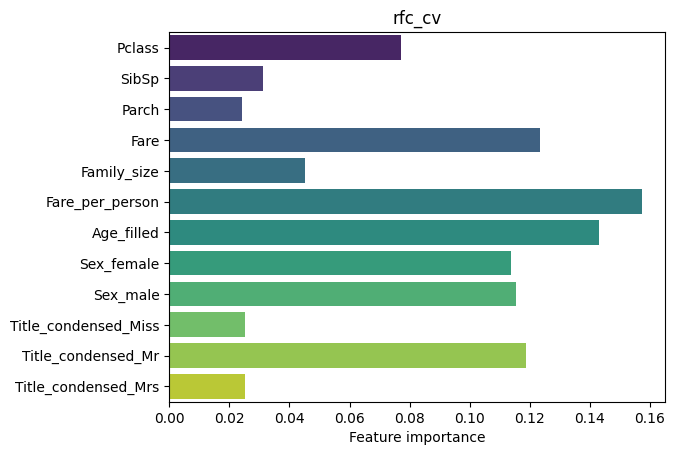

In [87]:
plot_feature_importance(rfc_cv, 'rfc_cv', X=X)